# Pythagorean expectation as predictor in Major League Baseball

One of the main reasons that people are interested in sports analytics is that they want to predict the outcome of events that have not yet occurred. Thus we want to go beyond "explanation" - finding the model that best fits the data (i.e. history) and to use our model to forecast the outcome of games in the future.

Pythagorean Expectation can be thought of as a forecast. At any point in the season, it can be calculated based on the games already played. Using it as a forecast would amount to saying that from that point onward the win percentage of the team would equal the Pythagorean Expectation to date. 

In this notebook, we're going to see if it is a good forecasting model in the context of the MLB data we examined earlier. Specifically, we will take the Pythagorean expectation based on games already played up to the All-Star Game (which takes place roughly in the middle of the season) and then see how well it correlates with win percentage in the second half of the season. We also have a natural benchmark against which to evaluate this forecast. The simplest forecast of all is to assume that win percentage will stay the same. Hence we will compare Pythagorean Expectation before the All-Star Game to win percentage before the All-Star Game as forecast of win percentage in the second half of the season.

To implement this test we initially follow the same procedures as we used in the previous MLB notebook to measure team performance. But then we split the data at the All-Star Game and compare statistics for each half of the season.


In [1]:
# Import packages

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the data

MLB = pd.read_excel('../Data/Retrosheet MLB game log 2018.xlsx')
print(MLB.columns.tolist())

['Date', 'DoubleHeader', 'DayOfWeek', 'VisitingTeam', 'VisitingTeamLeague', 'VisitingTeamGameNumber', 'HomeTeam', 'HomeTeamLeague', 'HomeTeamGameNumber', 'VisitorRunsScored', 'HomeRunsScore', 'LengthInOuts', 'DayNight', 'CompletionInfo', 'ForfeitInfo', 'ProtestInfo', 'ParkID', 'Attendence', 'Duration', 'VisitorLineScore', 'HomeLineScore', 'VisitorAB', 'VisitorH', 'VisitorD', 'VisitorT', 'VisitorHR', 'VisitorRBI', 'VisitorSH', 'VisitorSF', 'VisitorHBP', 'VisitorBB', 'VisitorIBB', 'VisitorK', 'VisitorSB', 'VisitorCS', 'VisitorGDP', 'VisitorCI', 'VisitorLOB', 'VisitorPitchers', 'VisitorER', 'VisitorTER', 'VisitorWP', 'VisitorBalks', 'VisitorPO', 'VisitorA', 'VisitorE', 'VisitorPassed', 'VisitorDB', 'VisitorTP', 'HomeAB', 'HomeH', 'HomeD', 'HomeT', 'HomeHR', 'HomeRBI', 'HomeSH', 'HomeSF', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeK', 'HomeSB', 'HomeCS', 'HomeGDP', 'HomeCI', 'HomeLOB', 'HomePitchers', 'HomeER', 'HomeTER', 'HomeWP', 'HomeBalks', 'HomePO', 'HomeA', 'HomeE', 'HomePassed', 'HomeDB',

In [3]:
# Create df containing only the variables we need
# Create a counter

MLB18 = MLB[['VisitingTeam','HomeTeam','VisitorRunsScored','HomeRunsScore','Date']]
MLB18 = MLB18.rename(columns={'VisitorRunsScored':'VisR','HomeRunsScore':'HomR'})
MLB18['count']=1
MLB18

,VisitingTeam,HomeTeam,VisR,HomR,Date,count
0,COL,ARI,2,8,20180329,1
1,PHI,ATL,5,8,20180329,1
2,SFN,LAN,1,0,20180329,1
3,CHN,MIA,8,4,20180329,1
4,SLN,NYN,4,9,20180329,1
...,...,...,...,...,...,...
2426,CHA,MIN,4,5,20180930,1
2427,TEX,SEA,1,3,20180930,1
2428,TOR,TBA,4,9,20180930,1
2429,MIL,CHN,3,1,20181001,1


In [4]:
# Create df recording team performance as home team
# We create an additional column 'home' which here has a value 1 to designate that these were home team games

MLBhome = MLB18[['HomeTeam','HomR','VisR','count','Date']].copy()
MLBhome['home']=1
MLBhome = MLBhome.rename(columns={'HomeTeam':'team','VisR':'RA','HomR':'R'})
MLBhome

,team,R,RA,count,Date,home
0,ARI,8,2,1,20180329,1
1,ATL,8,5,1,20180329,1
2,LAN,0,1,1,20180329,1
3,MIA,4,8,1,20180329,1
4,NYN,9,4,1,20180329,1
...,...,...,...,...,...,...
2426,MIN,5,4,1,20180930,1
2427,SEA,3,1,1,20180930,1
2428,TBA,9,4,1,20180930,1
2429,CHN,1,3,1,20181001,1


In [5]:
# Create df recording team performance as visiting team
# As above, we create an additional column 'home', which now has a value 0 to designate that these were away team games

MLBaway = MLB18[['VisitingTeam','VisR','HomR','count','Date']].copy()
MLBaway['home']=0
MLBaway = MLBaway.rename(columns={'VisitingTeam':'team','VisR':'R','HomR':'RA'})
MLBaway

,team,R,RA,count,Date,home
0,COL,2,8,1,20180329,0
1,PHI,5,8,1,20180329,0
2,SFN,1,0,1,20180329,0
3,CHN,8,4,1,20180329,0
4,SLN,4,9,1,20180329,0
...,...,...,...,...,...,...
2426,CHA,4,5,1,20180930,0
2427,TEX,1,3,1,20180930,0
2428,TOR,4,9,1,20180930,0
2429,MIL,3,1,1,20181001,0


In [6]:
# Here is where the approach differs from the previous notebooks. Instead of taking sums and averages, we first 
# concatenate, meaning that we stack performances as home team and away team. This creates a list of games played
# by each team across the season. The list is 4,862 rows long, which is twice the number of games played in the regular
# season. 

MLB18 = pd.concat([MLBhome,MLBaway])
MLB18

,team,R,RA,count,Date,home
0,ARI,8,2,1,20180329,1
1,ATL,8,5,1,20180329,1
2,LAN,0,1,1,20180329,1
3,MIA,4,8,1,20180329,1
4,NYN,9,4,1,20180329,1
...,...,...,...,...,...,...
2426,CHA,4,5,1,20180930,0
2427,TEX,1,3,1,20180930,0
2428,TOR,4,9,1,20180930,0
2429,MIL,3,1,1,20181001,0


In [7]:
# We define a win 

MLB18['win'] = np.where(MLB18['R']> MLB18['RA'],1,0)
MLB18

,team,R,RA,count,Date,home,win
0,ARI,8,2,1,20180329,1,1
1,ATL,8,5,1,20180329,1,1
2,LAN,0,1,1,20180329,1,0
3,MIA,4,8,1,20180329,1,0
4,NYN,9,4,1,20180329,1,1
...,...,...,...,...,...,...,...
2426,CHA,4,5,1,20180930,0,0
2427,TEX,1,3,1,20180930,0,0
2428,TOR,4,9,1,20180930,0,0
2429,MIL,3,1,1,20181001,0,1


In [8]:
# Now we define the season up to the All-Star Game (which was on July 17, 2018) as the first half of the season
# We use .describe() to show the summary statistics. You can see this includes 2,886 rows and therefore the results of
# 1,443 games.

Half1 = MLB18[MLB18.Date < 20180717]
Half1.describe()

,R,RA,count,Date,home,win
count,2886.000000,2886.000000,2886.0,2.886000e+03,2886.000000,2886.000000
mean,4.417533,4.417533,1.0,2.018054e+07,0.500000,0.500000
std,3.174305,3.174305,0.0,1.054102e+02,0.500087,0.500087
min,0.000000,0.000000,1.0,2.018033e+07,0.000000,0.000000
25%,2.000000,2.000000,1.0,2.018043e+07,0.000000,0.000000
50%,4.000000,4.000000,1.0,2.018052e+07,0.500000,0.500000
75%,6.000000,6.000000,1.0,2.018062e+07,1.000000,1.000000
max,20.000000,20.000000,1.0,2.018072e+07,1.000000,1.000000


In [9]:
# Now we define the season after the All-Star Game (which was on July 17, 2018) as the second half of the season
# We use .describe() to show the summary statistics. You can see this includes 1,976 rows and therefore the results of
# 988 games.


Half2 = MLB18[MLB18.Date > 20180717]
Half2.describe()

,R,RA,count,Date,home,win
count,1976.000000,1976.000000,1976.0,1.976000e+03,1976.000000,1976.000000
mean,4.494433,4.494433,1.0,2.018084e+07,0.500000,0.500000
std,3.219870,3.219870,0.0,7.011522e+01,0.500127,0.500127
min,0.000000,0.000000,1.0,2.018072e+07,0.000000,0.000000
25%,2.000000,2.000000,1.0,2.018081e+07,0.000000,0.000000
50%,4.000000,4.000000,1.0,2.018082e+07,0.500000,0.500000
75%,6.000000,6.000000,1.0,2.018091e+07,1.000000,1.000000
max,25.000000,25.000000,1.0,2.018100e+07,1.000000,1.000000


In [10]:
# We now use .groupby to sum the number of games, wins, runs and runs against for the first half of the season.

Half1perf = Half1.groupby('team').sum().loc[:,['count','win','R','RA']].reset_index()
Half1perf = Half1perf.rename(columns={'count':'count1','win':'win1','R':'R1','RA':'RA1'})
Half1perf

,team,count1,win1,R1,RA1
0,ANA,97,49,425,401
1,ARI,97,53,421,378
2,ATL,94,52,456,388
3,BAL,97,28,345,504
4,BOS,98,68,530,367
5,CHA,95,33,384,510
6,CHN,93,55,476,362
7,CIN,96,43,461,493
8,CLE,95,52,487,405
9,COL,96,51,467,468


In [14]:
# From these statistics we calculate win percentage and Pythagorean Expectation for the first half of the season.

Half1perf['wpc1'] = Half1perf['win1']/Half1perf['count1']
Half1perf['pyth1'] = Half1perf['R1']**2/(Half1perf['R1']**2 + Half1perf['RA1']**2)
Half1perf

,team,count1,win1,R1,RA1,wpc1,pyth1
0,ANA,97,49,425,401,0.505155,0.529031
1,ARI,97,53,421,378,0.546392,0.553662
2,ATL,94,52,456,388,0.553191,0.580049
3,BAL,97,28,345,504,0.288660,0.319067
4,BOS,98,68,530,367,0.693878,0.675908
5,CHA,95,33,384,510,0.347368,0.361805
6,CHN,93,55,476,362,0.591398,0.633566
7,CIN,96,43,461,493,0.447917,0.466495
8,CLE,95,52,487,405,0.547368,0.591158
9,COL,96,51,467,468,0.531250,0.498930


In [16]:
# As above we use .groupby to sum the number of games, wins, runs and runs against for the second half of the season.

Half2perf = Half2.groupby('team').sum().loc[:,['count','win','R','RA']].reset_index()
Half2perf = Half2perf.rename(columns={'count':'count2','win':'win2','R':'R2','RA':'RA2'})
Half2perf

,team,count2,win2,R2,RA2
0,ANA,65,31,296,321
1,ARI,65,29,272,266
2,ATL,68,38,303,269
3,BAL,65,19,277,388
4,BOS,64,40,346,280
5,CHA,67,29,272,338
6,CHN,70,40,285,283
7,CIN,66,24,235,326
8,CLE,67,39,331,243
9,COL,67,40,313,277


In [17]:
# From these statistics we calculate win percentage and Pythagorean Expectation for the second half of the season.

Half2perf['wpc2'] = Half2perf['win2']/Half2perf['count2']
Half2perf['pyth2'] = Half2perf['R2']**2/(Half2perf['R2']**2 + Half2perf['RA2']**2)
Half2perf

,team,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,65,31,296,321,0.476923,0.459548
1,ARI,65,29,272,266,0.446154,0.511151
2,ATL,68,38,303,269,0.558824,0.559231
3,BAL,65,19,277,388,0.292308,0.337607
4,BOS,64,40,346,280,0.625000,0.604272
5,CHA,67,29,272,338,0.432836,0.393055
6,CHN,70,40,285,283,0.571429,0.503521
7,CIN,66,24,235,326,0.363636,0.341948
8,CLE,67,39,331,243,0.582090,0.649789
9,COL,67,40,313,277,0.597015,0.560791


In [18]:
# Now we merge the two dfs

Half2predictor = pd.merge(Half1perf,Half2perf, on='team')
Half2predictor

,team,count1,win1,R1,RA1,wpc1,pyth1,count2,win2,R2,RA2,wpc2,pyth2
0,ANA,97,49,425,401,0.505155,0.529031,65,31,296,321,0.476923,0.459548
1,ARI,97,53,421,378,0.546392,0.553662,65,29,272,266,0.446154,0.511151
2,ATL,94,52,456,388,0.553191,0.580049,68,38,303,269,0.558824,0.559231
3,BAL,97,28,345,504,0.288660,0.319067,65,19,277,388,0.292308,0.337607
4,BOS,98,68,530,367,0.693878,0.675908,64,40,346,280,0.625000,0.604272
5,CHA,95,33,384,510,0.347368,0.361805,67,29,272,338,0.432836,0.393055
6,CHN,93,55,476,362,0.591398,0.633566,70,40,285,283,0.571429,0.503521
7,CIN,96,43,461,493,0.447917,0.466495,66,24,235,326,0.363636,0.341948
8,CLE,95,52,487,405,0.547368,0.591158,67,39,331,243,0.582090,0.649789
9,COL,96,51,467,468,0.531250,0.498930,67,40,313,277,0.597015,0.560791


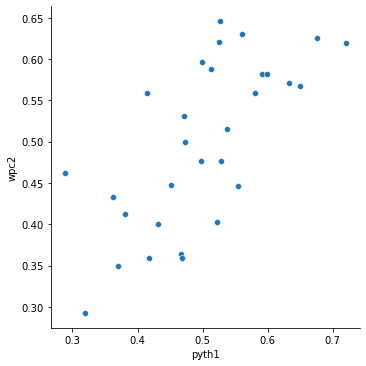

In [19]:
# First, plot Pythagorean Expectation against win percentage in the second half of the season

sns.relplot(x="pyth1", y="wpc2", data = Half2predictor)

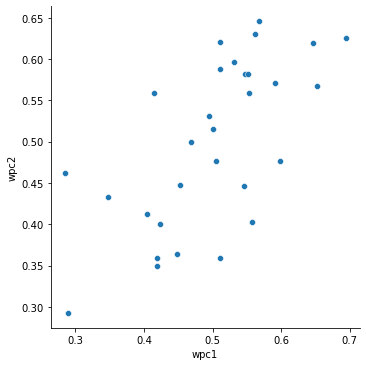

In [20]:
# Now, compare this with a plot of win percentage from the first half of the season against win percentage
#in the second half of the season


sns.relplot(x="wpc1", y="wpc2", data = Half2predictor)

In [21]:
# The two plots look similar
# We can be more precise still if we compare the correlation coefficients. The first row of the table shows the 
# correlation of win percentage in second half of the season against itself, win percentage in the first half of the season,
# Pythagorean Expectation in the first half of the season, and Pythagorean Expectation in the second half of the season.
# Our focus is on comparing the second and third columns.

keyvars = Half2predictor[['team','wpc2','wpc1','pyth1','pyth2']]
keyvars.corr()

,wpc2,wpc1,pyth1,pyth2
wpc2,1.000000,0.652549,0.690752,0.924473
wpc1,0.652549,1.000000,0.941082,0.577847
pyth1,0.690752,0.941082,1.000000,0.659521
pyth2,0.924473,0.577847,0.659521,1.000000


In [22]:
# We can also sort the variables to show for each club how close the relationships are between the first and second half
# of the season

keyvars = keyvars.sort_values(by=['wpc2'],ascending=False)
keyvars

,team,wpc2,wpc1,pyth1,pyth2
19,OAK,0.646154,0.567010,0.527439,0.681224
15,MIL,0.630769,0.561224,0.560795,0.574983
4,BOS,0.625000,0.693878,0.675908,0.604272
26,TBA,0.621212,0.510417,0.525559,0.585571
11,HOU,0.619048,0.646465,0.719748,0.641553
9,COL,0.597015,0.531250,0.498930,0.560791
25,SLN,0.588235,0.510638,0.513494,0.589046
8,CLE,0.582090,0.547368,0.591158,0.649789
13,LAN,0.582090,0.552083,0.598539,0.683228
6,CHN,0.571429,0.591398,0.633566,0.503521


# Conclusion

We can see from the correlation matrix that win percentage in the second half of the season is correlated with win percentage in the first half of the season - the correlation coefficient is +0.653. It's not surprising that performance in the first half of the season is to an extent predictive of performance in the second half. But there are also clearly things that can change. 

When we sort the teams from highest to lowest send half of season win percentage, we find a mixed picture. Some clubs perform with less than one percentage point difference in each half, e.g. The Brave (ATL), the Padres (SDN) or the Orioles (BAL), while others differed by more than ten percentage points, e.g. the Rays (TBA), the Mets (NYN) or the Mariners (SEA).

We could simply use first half win percentage as a predictor of second half win percentage, but when we look at the correlation matrix we can see that the Pythagorean Expectation is an even better forecast - the correlation coefficient is higher, at +0.691. To be sure, the difference is not large, but it is slightly better. This was, in fact, the initial impetus for Bill James when introducing the statistic. He argued that a win could ride on lucky hit and the difference of just one run, which made wins a less reliable predictor than the aggregate capacity to produce runs and limit conceding runs. As in many aspects of baseball analysis, our data show that James was quite right.